In [1]:
import nomic
import json

api_key_path = "/home/paperspace/api_keys.json"

with open(api_key_path, 'r') as j:
    key = json.loads(j.read())['nomic']

nomic.login(key)
import numpy as np
import pandas as pd
from tqdm import tqdm

import transformers
from sentence_transformers import SentenceTransformer
import torch

#- Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#- Data
from nomic import AtlasDataset

#- Processing
from fuzzywuzzy import fuzz
from unidecode import unidecode
import re
import datetime

dataset = AtlasDataset('hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-10-08')

df = dataset.maps[0].data.df
embds = dataset.maps[0].embeddings.latent

df.head()

/home/paperspace/venvs/pnma/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
2024-10-15 23:05:56.268 | INFO     | nomic.dataset:__init__:761 - Loading existing dataset `hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-10-08`.
2024-10-15 23:05:57.150 | WARNING  | nomic.data_operations:df:923 - Converting to pandas dataframe. This may materialize a large amount of data into memory.
2024-10-15 23:05:57.151 | INFO     | nomic.data_operations:_download_data:902 - Downloading data
100%|██████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 10403.90it/s]
2024-10-15 23:05:57.475 | INFO     | nomic.data_operations:_load_data:872 - Loading data
100%|████████████████████████████████████████████████████████████████████

,tweetId,postedAt,name,state,party,twitter_lower,chamber,years,source,id,text
0,1065633444502224896,2018-11-22 15:49:46.338,Ken Buck R-CO,CO,R,repkenbuck,House,2017_2018,PolitWoops,1203633,Happy #Thanksgiving! I hope everyone has a cha...
1,1479108462504136704,2022-01-06 15:11:52.624,Kat Cammack R-FL,FL,R,repkatcammack,House,2021_2022,PolitWoops,2857207,"RT @MorningsMaria: .@RepKatCammack: ""The Democ..."
2,85108215381102592,2011-06-26 22:12:34.438,Dennis Ross R-FL,FL,R,repdennisross,House,2011_2012,PolitWoops,35353,@CEP_Observer will have to check that out.
3,925691081026621440,2017-11-01 11:48:46.882,Richard Hudson R-NC,NC,R,reprichhudson,House,2017_2018,PolitWoops,954870,RT @BGClubCab: Thanks to @CharlotteWBB for hel...
4,1435963943533568000,2021-09-09 13:50:57.715,Chip Roy R-TX,TX,R,repchiproy,House,2021_2022,PolitWoops,2324693,RT @chiproytx: No. https://t.co/STZW0DdDz1


In [56]:
def capitalize_first_letters(name, delimiter=' '):
    recon=''
    chunks = name.split(delimiter)
    
    for chunk in chunks:
        recon += chunk[0].upper() + chunk[1:] + ' '
        
    return recon.strip()

def get_tweet_start(text, n_characters=30):
    chunks = text.split(' ')

    text_ = chunks[0]
    len_text = len(text_)

    c=1
    while len_text < n_characters and c < len(chunks)-1:
        text_ += ' ' + chunks[c]
        len_text = len(text_)
        c+=1

    return text_, len(chunks) - c

def remove_quotes(tweet, quote_list = ['"', "'", b'\xe2\x80\x9c'.decode()]):
    removed_first_quote = False
    while not removed_first_quote:
        if tweet in quote_list:
            tweet = tweet[1:]
        else:
            removed_first_quote=True

    removed_last_quote = False
    while not removed_first_quote:
        if tweet[-1] in quote_list:
            tweet = tweet[:-1]
        else:
            removed_last_quote=True
            
    if tweet[0] in quote_list:
        tweet = tweet[1:]
    if tweet[-1] in quote_list:
        tweet = tweet[:-1]
        
    return tweet.strip()

In [2]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="cuda:0",
)

embedding_model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
<All keys matched successfully>


In [3]:
congress_name_list= list(df['name'].unique())    
name_to_standardized_name = {}

t = pd.Timestamp(year=2023, month=1, day=1)

for name in congress_name_list:
    key = name
    name = name.lower()
    chunks = name.split(' ')[:2]
    if ',' in chunks[0]:
        name = chunks[1] + '_' + chunks[0][:-1]
    else:
        name = chunks[0] + '_' + chunks[1]
        
    name_to_standardized_name[key] = unidecode(name)
        
standardized_name_list = list(name_to_standardized_name.values())

n_congresspersons = len(congress_name_list)
all_text = {name: {'pre-t': [], 'post-t': []} for name in standardized_name_list}
all_embds = {name: {'pre-t': [], 'post-t': []} for name in standardized_name_list}

for i, embd in enumerate(tqdm(embds)):
    congress_name = name_to_standardized_name[df['name'][i]]
    posted_at = df['postedAt'][i]
    
    if posted_at > t:
        key='post-t'
    else:
        key='pre-t'
        
    all_text[congress_name][key].append(df['text'][i])
    all_embds[congress_name][key].append(embd)
    
for name in standardized_name_list:
    all_embds[name]['post-t'] = np.array(all_embds[name]['post-t'])
    all_embds[name]['pre-t'] = np.array(all_embds[name]['pre-t'])

100%|██████████████████████████████████████████████████████████████████████| 3214913/3214913 [00:56<00:00, 57382.53it/s]


In [4]:
np.random.seed(1)
shuffled_cps = np.random.choice(standardized_name_list, len(standardized_name_list), replace=False)
n_tweets_per_cp = 100

timeframes = ['pre-t', 'post-t']
sampled_tweet_dict = {}

name = 'morgan_griffith'
tweets = all_text[name]['post-t']
shuffled_tweets = np.random.choice(tweets, len(tweets), replace=False)
sampled_tweet_dict[name] = {'real': shuffled_tweets[:n_tweets_per_cp], 
                            'to-be-generated': shuffled_tweets[n_tweets_per_cp: 2*n_tweets_per_cp]
                           }

n_cps = 100
for name in shuffled_cps:
    #- only consider n_cps congresspersons
    if len(sampled_tweet_dict) >= n_cps:
        break
        
    tweets = all_text[name]['post-t']
    #- only consider congresspersons with enough tweets after t
    if len(tweets) < 2 * n_tweets_per_cp or len(all_text[name]['pre-t']) == 0:
        continue
        
    shuffled_tweets = np.random.choice(tweets, len(tweets), replace=False)
    sampled_tweet_dict[name] = {'real': shuffled_tweets[:n_tweets_per_cp], 
                                'to-be-generated': shuffled_tweets[n_tweets_per_cp: 2*n_tweets_per_cp],
                                'generated': [],
                                'no-system-no-rag': [],
                                'system-no-rag': [],
                                'system-rag': []
                               }
    
sampled_tweet_dict.keys()

dict_keys(['morgan_griffith', 'henry_cuellar', 'veronica_escobar', 'jared_huffman', 'brian_mast', 'byron_donalds', 'maria_salazar', 'michael_cloud', 'jay_obernolte', 'jan_schakowsky', 'marco_rubio', 'james_comer', 'gus_bilirakis', 'a._ferguson', 'pat_fallon', 'julia_brownley', 'jeff_duncan', 'kevin_mccarthy', 'barry_loudermilk', 'jennifer_wexton', 'john_thune', 'kirsten_gillibrand', 'lance_gooden', 'jack_reed', 'joe_neguse', 'jake_laturner', 'bill_hagerty', 'dina_titus', 'chrissy_houlahan', 'mike_crapo', 'david_joyce', 'mary_scanlon', 'josh_hawley', 'ron_estes', 'dan_kildee', 'maggie_hassan', 'abigail_spanberger', 'frederica_wilson', 'gerald_connolly', 'joaquin_castro', 'david_rouzer', 'tammy_baldwin', 'ted_lieu', 'charles_schumer', 'mark_desaulnier', 'frank_mrvan', 'tim_kaine', 'clay_higgins', 'tim_burchett', 'marcy_kaptur', 'diana_degette', 'andy_barr', 'ami_bera', 'kevin_hern', 'kay_granger', 'raul_grijalva', 'william_keating', 'james_lankford', 'lisa_mcclain', 'ted_budd', 'young_ki

In [5]:
gen_type_list = ['no-system-no-rag', 'system-no-rag', 'system-rag']

terminators = [
    pipeline.tokenizer.eos_token_id,
    pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

pipeline.tokenizer.pad_token_id = pipeline.model.config.eos_token_id
pipeline.tokenizer.padding_side = 'left'

for name in tqdm(sampled_tweet_dict):
    proper_noun_name = capitalize_first_letters(name.replace('_', ' '))
    for gen_type in gen_type_list:
        if 'no-rag' not in gen_type:
            retrieved_tweet_indices = np.argmax(all_embds[name]['pre-t'] @ embedding_model.encode(sampled_tweet_dict[name]['to-be-generated']).T, axis=0)
        
        if 'no-system' in gen_type:
            system_prompt = "You are a helpful assistant."
        else:
            system_prompt = f"You are U.S. congressperson {proper_noun_name}."
        
        message_list = []
        for i,to_be_generated in enumerate(sampled_tweet_dict[name]['to-be-generated']):
            to_be_generated_start = get_tweet_start(to_be_generated, n_characters=20)[0]
            
            user_prompt = f'Complete the following Tweet: {to_be_generated_start}.'
            if 'no-rag' not in gen_type:
                retrieved_tweet = all_text[name]['pre-t'][retrieved_tweet_indices[i]]
                user_prompt += f' Here is an example Tweet potentially related to the to-be-completed Tweet: "{retrieved_tweet}".'
            user_prompt += ' Respond with the full Tweet.'
            
            messages = [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ]
            
            message_list.append(messages)
        
        outputs = pipeline(
            message_list,
            batch_size=50,
            max_new_tokens=64,
            eos_token_id=terminators,
            do_sample=False
        )
        
        sampled_tweet_dict[name][gen_type] = [o[0]["generated_text"][-1]['content'] for o in outputs]
        sampled_tweet_dict[name][gen_type] = [t.split('Here is the completed Tweet:')[-1].strip() for t in sampled_tweet_dict[name][gen_type]]
        sampled_tweet_dict[name][gen_type] = [remove_quotes(t) for t in sampled_tweet_dict[name][gen_type]]
        
        
pipeline.model.to('cpu')
del pipeline

import gc
gc.collect()
torch.cuda.empty_cache()

  0%|                                                                                           | 0/100 [00:00<?, ?it/s]/home/paperspace/venvs/pnma/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/paperspace/venvs/pnma/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` 

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 28%|██████████████████████▉                                                           | 28/100 [19:21<49:36, 41.34s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 29%|███████████████████████▊                                                          | 29/100 [20:02<49:00, 41.42s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 43%|███████████████████████████████████▎                                              | 43/100 [29:39<39:03, 41.12s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 44%|████████████████████████████████████                                              | 44/100 [30:20<38:18, 41.05s/it]Setting `pad_token_id` to `eos

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 72%|███████████████████████████████████████████████████████████                       | 72/100 [49:35<19:15, 41.26s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 73%|███████████████████████████████████████████████████████████▊                      | 73/100 [50:16<18:32, 41.19s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 87%|███████████████████████████████████████████████████████████████████████▎          | 87/100 [59:54<08:57, 41.34s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 88%|██████████████████████████████████████████████████████████████████████▍         | 88/100 [1:00:36<08:16, 41.39s/it]Setting `pad_token_id` to `eos

In [63]:
import pickle
pickle.dump(sampled_tweet_dict, open('sampled_tweet_dict.p', 'wb'))

In [14]:
filtered_sampled_tweet_dict = {}
for name in sampled_tweet_dict:
    filtered_sampled_tweet_dict[name] = {}
    for gen_type in sampled_tweet_dict[name]:
        filtered_sampled_tweet_dict[name][gen_type] = []
        for tweet in sampled_tweet_dict[name][gen_type]:
            if 'I cannot' not in tweet[:10]:
                filtered_sampled_tweet_dict[name][gen_type].append(tweet)

In [28]:
from graspologic.embed import ClassicalMDS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
gen_type_list = ['no-system-no-rag', 'system-no-rag', 'system-rag']
detecability_dict = {gen_type: {} for gen_type in ['to-be-generated'] + gen_type_list}

for name in sampled_tweet_dict:
    for gen_type in ['to-be-generated'] + gen_type_list:
        generated_tweets = list(filtered_sampled_tweet_dict[name][gen_type])
        n_generated = len(generated_tweets)
        
        real_tweets = list(sampled_tweet_dict[name]['real'])[:n_generated]
        tweets = embedding_model.encode(real_tweets + generated_tweets)
        labels = [0 for i in range(n_generated)] + [1 for i in range(n_generated)]
        cmds_embds = ClassicalMDS().fit_transform(tweets)
        lda_model = LinearDiscriminantAnalysis().fit(cmds_embds, labels)
        lda_embds = lda_model.transform(cmds_embds)

        detectability = 1 - np.mean(lda_model.predict(cmds_embds) != labels) / 0.5

        detecability_dict[gen_type][name] = detectability

-0.05 0.05
0.95 1.05
1.95 2.05
2.95 3.05


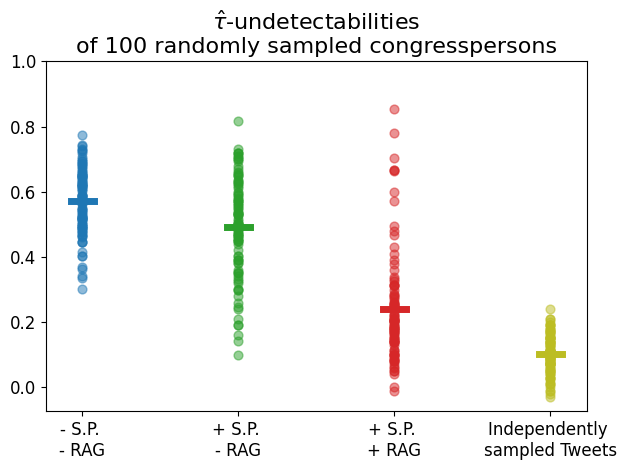

In [67]:
fig, ax = plt.subplots(1,1)
color_dict={'to-be-generated': 'tab:olive',
              'no-system-no-rag': 'tab:blue',
              'system-no-rag': 'tab:green',
              'system-rag': 'tab:red'
             }

for i, gen_type in enumerate(gen_type_list + ['to-be-generated']):
    detectabilities = list(detecability_dict[gen_type].values())
    average_detectability = np.mean(detectabilities)
    ax.scatter(len(sampled_tweet_dict) * [i], detectabilities, s=40, color=color_dict[gen_type], alpha=0.5)
    print(i-0.05, i+0.05)
    ax.plot([i-0.075, i+0.075], 2*[average_detectability],lw=5, color=color_dict[gen_type])
    
    
tick_labels= ['Generic system prompt \nw/ no augmentation', 
              'Tailored system prompt \nw/ no augmentation', 
              'Tailored system prompt \nw/ no augmentation',
              'Independently \nsampled Tweets']

tick_labels= ['- S.P. \n- RAG', 
              '+ S.P. \n- RAG', 
              '+ S.P. \n+ RAG',
              'Independently \nsampled Tweets']
ax.set_xticks(ticks=[0,1,2,3], labels=tick_labels)
# ax.set_xlim(-0.2, 2.2)
ax.set_yticks([0, 0.2, 0.4 ,0.6, 0.8, 1])

ax.tick_params(labelsize=12)
ax.set_title(r'$ \hat{\tau} $-undetectabilities' '\nof 100 randomly sampled congresspersons', fontsize=16)
plt.tight_layout()
plt.savefig('tau-undetectabilities.pdf', bbox_inches='tight')
plt.savefig('tau-undetectabilities.png', bbox_inches='tight', dpi=500)

In [26]:
argmax = np.argmax(list(detecability_dict[gen_type].values()))
filtered_sampled_tweet_dict[list(filtered_sampled_tweet_dict.keys())[argmax]]['system-rag']

["Do not be amazed, when the world's values and priorities are turned upside down and the very things that once brought you fame and fortune are now seen as foolishness. Blessed are you when people hate you, and when they exclude and insult you, and denounce your name as evil on",
 'Here\'s the completed Tweet:\n\n"We need to make things in America again! But it\'s not just about manufacturing jobs, it\'s about rebuilding our communities and restoring the American Dream. That\'s why I\'m committed to policies that support Faith, Family and Community. #Sayfie',
 'Here\'s the completed Tweet:\n\n"Oil is up $15 a barrel. The same leftist Democrats who want to end American oil production are mad that other countries aren’t producing more oil. Meanwhile, I\'m working to increase American energy production, lower prices, and make our country more energy independent. #MAGA',
 'Reports that Maduro regime is using the release of 7 innocent Americans as leverage to get more concessions from the 

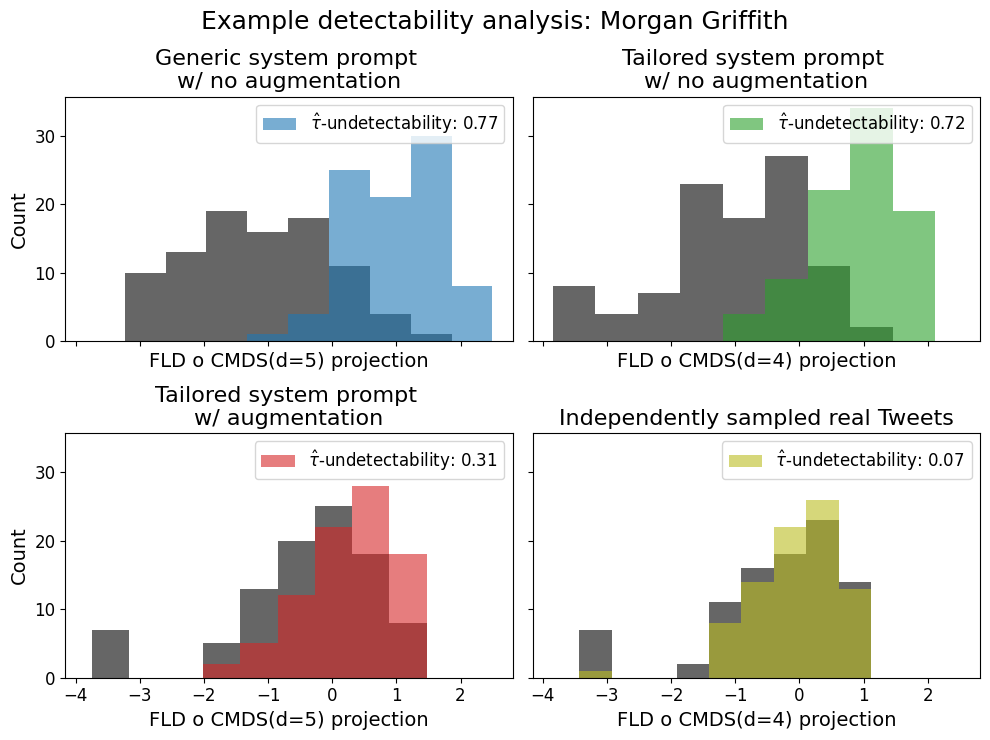

In [70]:
title_dict = {'no-system-no-rag': 'Generic system prompt \nw/ no augmentation',
              'system-no-rag': 'Tailored system prompt \nw/ no augmentation',
              'system-rag': 'Tailored system prompt \nw/ augmentation',
              'to-be-generated': 'Independently sampled real Tweets'
             }

name = 'morgan_griffith'
fig, ax = plt.subplots(2,2, figsize=(10,7.5), sharey=True, sharex=True)
for i,gen_type in enumerate(gen_type_list + ['to-be-generated']):
    row = i // 2
    col = i % 2
    
    generated_tweets=  list(filtered_sampled_tweet_dict[name][gen_type])
    n_generated = len(generated_tweets)
    
    real_tweets = list(sampled_tweet_dict[name]['real'])[:n_generated]
    
    tweets = embedding_model.encode(generated_tweets + real_tweets)
    labels = [0 for i in range(n_generated)] + [1 for i in range(n_generated)]
    
    cmds_embds = ClassicalMDS().fit_transform(tweets)
    lda_model = LinearDiscriminantAnalysis().fit(cmds_embds, labels)
    lda_embds = lda_model.transform(cmds_embds)
    
    min_ = np.min(lda_embds)
    max_ = np.max(lda_embds)
    
    h = (max_ - min_) / 10
    bins = [min_ + i*h for i in range(10)]
    
    detectability = 1 - np.mean(lda_model.predict(cmds_embds) != labels) / 0.5
    if gen_type == 'no-system-no-rag':
        ax[row,col].hist(lda_embds[:n_generated], bins=bins,color='k', alpha=0.6)
    else:
        ax[row,col].hist(lda_embds[:n_generated], bins=bins, color='k', alpha=0.6)

    label = r'$ \hat{\tau} $'+ f'-undetectability: {detectability:1.2f}'
    ax[row,col].hist(lda_embds[n_generated:], bins=bins, color=color_dict[gen_type], alpha=0.6, label=label)
    
    ax[row,col].set_title(title_dict[gen_type], fontsize=16)
    ax[row,col].legend(fontsize=12, loc='upper right')
    ax[row,col].tick_params(labelsize=12)
    ax[row,col].set_xlabel(f'FLD o CMDS(d={cmds_embds.shape[1]}) projection', fontsize=14)

ax[0,0].set_ylabel('Count', fontsize=14)
ax[1,0].set_ylabel('Count', fontsize=14)
fig.suptitle(f'Example detectability analysis: {capitalize_first_letters(name.replace("_", " "))}', y=0.98, fontsize=18)

plt.tight_layout()
plt.savefig('example_detectability.png', bbox_inches='tight', dpi=500)
plt.savefig('example_detectability.pdf', bbox_inches='tight')